In [35]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, Flatten, Reshape, LeakyReLU, Dropout, BatchNormalization
import numpy as np
import matplotlib.pyplot as plt

In [36]:
def preprocess(image, label):
    image = tf.image.resize(image, [64, 64])  # Resize images to 64x64
    image = tf.cast(image, tf.float32) / 255.0  # Normalize images to [0, 1]
    return image

In [37]:
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    'malaria',
    split=['train[:70%]', 'train[70%:85%]', 'train[85%:]'],
    as_supervised=True,
    with_info=True,
)

In [38]:
batch_size = 32
ds_train = ds_train.map(preprocess).shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
ds_val = ds_val.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [39]:
def make_generator_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(8*8*256, use_bias=False, input_shape=(100,)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Reshape((8, 8, 256)),
        tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])
    return model

In [40]:
def make_discriminator_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[64, 64, 3]),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1)
    ])
    return model

In [41]:
generator = make_generator_model()
discriminator = make_discriminator_model()

# Loss and optimizer
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [42]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


In [43]:
@tf.function
def train_step(images, generator, discriminator, generator_optimizer, discriminator_optimizer):
    noise = tf.random.normal([batch_size, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [44]:
def train(dataset, epochs, generator, discriminator, generator_optimizer, discriminator_optimizer):
    for epoch in range(epochs):
        for image_batch in dataset:
            train_step(image_batch, generator, discriminator, generator_optimizer, discriminator_optimizer)

# Train the GAN
epochs = 10
train(ds_train, epochs, generator, discriminator, generator_optimizer, discriminator_optimizer)

# Save the models
generator.save('malaria_cell_generator.h5')
discriminator.save('malaria_cell_discriminator.h5')


/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


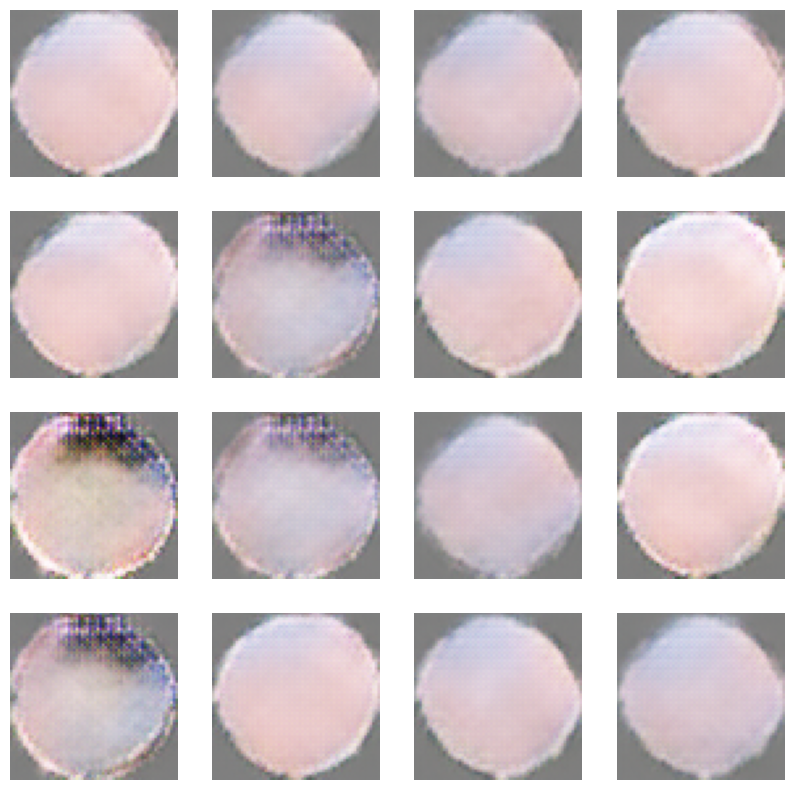

In [45]:
def display_images(images):
    plt.figure(figsize=(10, 10))
    for i in range(images.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow((images[i, :, :, :] * 0.5 + 0.5))  # Rescale the images to the 0-1 range
        plt.axis('off')
    plt.show()

# Generate and display images
noise = tf.random.normal([16, 100])  # Generate 16 images to display
generated_images = generator(noise)
display_images(generated_images.numpy())